In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
tfd = tfp.distributions

/home/mkinet/Dev/venv/python3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/mkinet/Dev/venv/python3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Credits:
All credits goes to mkinet (https://github.com/mkinet) for his work on this notebook that really helped me to understand the key concept in bayesian inference.

# Introduction

The goal of this notebook is to investigate Bayesian logistic regression, and in particular compare its predictions with regular logistic regression.
To perform Bayesian inference, we will use a basic monte-carlo Markov chain (MCMC) approach which will be implemented from scratch in tensorflow probability. 

This helps to understand how bayesian neural networks might work since, in the end, a logistic regression is nothing more than a one-layer (no-hidden layer) neural network. 

# Generate some data
As a first step, we will generate some artificial data suitable for logistic regression. We will restrict ourselves to 2D data as this will ease visualization and assume that each data point come from one of two distinct gaussian distributions which we want to distinguish. Furthermore, we deliberately set ourselves in a scarce data framework, which is where the strength of Bayesian methods are most obvious. 

We choose thus to have 10 points per class. The dataset is shown in the figure below.

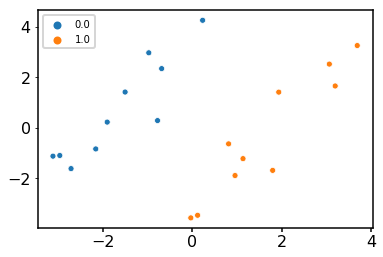

In [2]:
def make_scatter_plot(sample, y, *args, **kwargs):
    sns.scatterplot(sample[:, 0], sample[:, 1], hue=y.flatten(), *args,
                    **kwargs)

def make_data(n=80):
    with tf.Graph().as_default():
        tf.set_random_seed(526)
        d1 = tfd.MultivariateNormalTriL(loc=[2., 0.],
                                        scale_tril=[[1.2, 0.0], [2.0,1.2]],
                                        validate_args=True)
        sample1 = d1.sample(n)
        y1 = tf.ones(n)

        d2 = tfd.MultivariateNormalTriL(loc=[-2., 0.],
                                        scale_tril=[[1.2, 0.0], [2.0, 1.2]],
                                        validate_args=True)
        sample2 = d2.sample(n)
        y2 = tf.zeros(n)
        sample = tf.concat([sample1, sample2], axis=0)
        labels = tf.concat([y1, y2], axis=0)

        sample = tf.random_shuffle(sample, seed=987)
        labels = tf.random_shuffle(labels, seed=987)

        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            x, y = sess.run([sample, labels])
        y = np.reshape(y, [len(y), 1])

    return x, y
tf.reset_default_graph()
data, y = make_data(10)
make_scatter_plot(data, y)

This seems pretty straightforward for a classification problem: the dataset is linearly separable.

# Logistic regression

Let us start by applying a logistic regression. 
Let us denote by $X_0$ and $X_1$ the two features of our 2D dataset. Logistic regression makes classification on the basis of a sigmoid applied to a linear combination of the predictors :
$$ f(X) = \sigma(W_0X_0+W_1X_1 +b)$$
where $\sigma$ denotes the sigmoid.
The free parameters $W_0$, $W_1$ and $b$ are chosen to minimize the cross entropy of the training set prediction vs. the labels. Note that it is not a plain vanilla logistic regression because we added a regularization term. This is equivalent to making an a-posteriori optimization of the likelihood. The optimum is found by mean of a simple gradient descent optimizer.

In [3]:
def logistic_regression(train_x, train_y):
    # Parameters
    learning_rate = .5
    training_epochs = 1000
    display_step = 100
    lam = 1.e-3

    # tf Graph Input
    x = tf.placeholder(tf.float32, [None, 2])
    y = tf.placeholder(tf.float32, [None, 1])

    # Set model weights
    W = tf.Variable(tf.random_normal([2, 1], seed=234))
    b = tf.Variable(tf.zeros(1))
    # Construct model
    logits = tf.matmul(x, W) + b
    pred = tf.sigmoid(logits)
    # Minimize error using cross entropy
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,
                                                                  labels=y)) +\
        lam*tf.nn.l2_loss(W)
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    # Start training
    with tf.Session() as sess:
        # Run the initializer
        sess.run(init)
        # Training cycle
        for epoch in range(training_epochs):
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c, W_opt, b_opt = sess.run([optimizer, cost, W, b], feed_dict={x: train_x,
                                                                              y: train_y})
            # Display logs per epoch step
            if (epoch+1) % display_step == 0:
                print("Epoch:", '%04d' %
                      (epoch+1), "cost=", "{:.9f}".format(c))

    return W_opt, b_opt

def sigmoid(w0,w1,b,x0,x1):
    return 1/(1+np.exp(-(w0*x0[None,:]+w1*x1[:,None]+b)))

W_opt, b_opt = logistic_regression(data, y)

Epoch: 0100 cost= 0.017426342
Epoch: 0200 cost= 0.013711227
Epoch: 0300 cost= 0.012723101
Epoch: 0400 cost= 0.012345405
Epoch: 0500 cost= 0.012176611
Epoch: 0600 cost= 0.012094310
Epoch: 0700 cost= 0.012051892
Epoch: 0800 cost= 0.012029160
Epoch: 0900 cost= 0.012016617
Epoch: 1000 cost= 0.012009524


Once the logistic regression is trained, we can draw a decision boundary, which correspond to an output of the regression equal 0.5. Furthermore, we can draw a contour plot of the value of the prediciton in the plane ($X_0$, $X_1$). We can observe that this contour plot is linear.

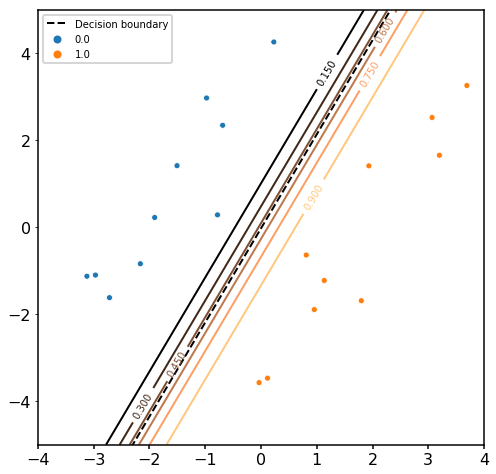

In [4]:
x0 = np.linspace(-4., 4.,200)
x1 = np.linspace(-5., 5., 200)
X0, X1 = np.meshgrid(x0, x1)
val = sigmoid(W_opt[0], W_opt[1], b_opt, x0, x1)
fig, ax = plt.subplots(1,1,figsize=(8,8))
make_scatter_plot(data,y, ax=ax)
cs = ax.contour(X0, X1, val, cmap='copper')
plt.clabel(cs, inline=True,fontsize=10)
ax.plot(x0,-W_opt[0]/W_opt[1]*x0-b_opt/W_opt[1],'k--', label='Decision boundary')
ax.set_xlim(-4.0,4.0)
ax.set_ylim(-5.0,5.0)
ax.legend()

# Bayesian logistic regression

Let us now turn to the Bayesian logistic regression. We will implement all the methods we need from scratch to understand all the details of what is happening under the hood, even if that leads to a huge lack of computational efficiency.

The general idea in Bayesian statistic is to compute the full posterior distribution of the unknown parameters given the data, i.e. in our case the quantity $P(b, W_0, W_1 | X_0, X_1, Y)$. From there, to make a prediction for a new point, we want to compute the expectation of the output of the logistic regression under that posterior distribution:
$$ f(X^*) = \int_{b, W_0, W_1} \sigma(W_0X_0^*+W_1X_1^*+b)* P(b, W_0, W_1 | X, X, Y) dW$$

where $\sigma$ denotes the sigmoid function, and $dW$ is the element off volume in the 3D parameter space.

There are two diffculties in this approach : 

1. we cannot compute easily the posterior. 
2. even if we could, the expectation integral would still be a challenging calculation.

(for the toy-problem we have here, we could rely on discretization and enumeration, but in high dimensions this is completely hopeless, so let us explore what we should do in that case).

Both problems are solved in practice by sampling the posterior. Indeed, if we can draw samples from the posterior, we can approximate the posterior by an histogram of the samples, and more importantly, we can approximate the expectation by computing the sigmoid for each sample and sum them together. 

Thus the challenge is to be able to create a suite of triplets (b, W_0,W_ 1) whose probability of occurence is consistent with the posterior distribution.

One such method is called the Metropolis-Hastings algorithm (it the most simple form of MCMC sampling), which goes as follows :

  1. Start from a random location in the parameter space.
  2. Compute the (log-)likelihood of that point and multiply by its prior to obtain the numerator of Bayes rule.
  3. Randomly sample a new point in the neighborhood of the previous point
  4. Compute its (log-)likelihood and multiply by the prior.
  5. If the new point is more likely than the previous point, add it to the chain and move to that location.
  6. If the new point is not more likely:
      * stay at the current location with probability $1-p$, or 
      * move to the new location with probability $p$.
  7. repeat steps 3 to 6 for a pre-defined number of iterations (typically a few thousands).

In the end, we ends up with a list of visited location whose frequency of occurence correspond to the posterior distribution. In general, the first few samples are thrown away to eliminate the possible influence of the initial condition.

Step 6 ensures that we are never stuckin a region of very high probability and that we are able to explore the parameter space for as long as we want.

The algorithm is implemented below in tensorflow.


In [5]:
def metropolis_hasting(train_x, train_y, niter=11000, warmup=1000, seed=234, 
                       proposal='Gaussian'):
    lam = 50.e-0
    # Generate start point
    W = tf.Variable(tf.random_normal([2, 1], seed=seed))
    b = tf.Variable(tf.zeros([1, 1]))
    W_new = tf.Variable(tf.zeros([2, 1]))
    b_new = tf.Variable(tf.zeros([1, 1]))
    # tf Graph Input
    x = tf.placeholder(tf.float32, [None, 2])
    y = tf.placeholder(tf.float32, [None, 1])

    def log_like(w_test,b_test):
        logits = tf.matmul(x, w_test) + b_test
        prior = tfd.Normal(loc=tf.zeros(3),scale = 10.)
        like = tfd.Bernoulli(logits=logits)
        log = tf.reduce_sum(like.log_prob(y)) + \
                tf.reduce_sum(prior.log_prob(tf.concat([w_test, b_test],axis=0)))
        return log

    # propose new location
    W_new = W + tf.random_normal([2, 1], stddev=0.1)
    b_new = b + tf.random_normal([1, 1], stddev=0.1)
    # compute log-likelihood ratio
    rat = tf.minimum(tf.exp(tf.subtract(log_like(W_new, b_new),log_like(W,b))),1.0)
    
    # update position
    coin = tfd.Bernoulli(probs=[rat])
    accept_change = tf.equal(tf.reshape(coin.sample(),[]),1)
    sam_w = tf.cond(accept_change, lambda: W.assign(W_new),
                                      lambda: tf.identity(W))
    sam_b = tf.cond(accept_change, lambda: b.assign(b_new),
                                      lambda: tf.identity(b))
    sample = tf.concat([sam_w,sam_b], axis=0)
    # initialiaze output
    chain = np.ndarray([niter,3, 1])
    ratio = np.ndarray([niter, 1])
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        # Run the initializer
        sess.run(init)
        for i in range(niter):
            r, sam = sess.run([rat, sample], 
                                feed_dict={x: train_x, y: train_y})
            chain[i,:,:] = sam
            ratio[i] = r
    return chain[warmup:], ratio
tf.reset_default_graph()
sample, ratio = metropolis_hasting(data,y,niter=20000, warmup=2000)
w0 = sample[:,0,0]
w1 = sample[:,1,0]
b = sample[:,2,0]

We can have a look at the marginal distributions of the three unknown parameter by representing their histogram of occurence in the chain : 

(array([  11.,   27.,   60.,  168.,  177.,  331.,  521.,  723.,  795.,
         699.,  488.,  431.,  395.,  511.,  783., 1044., 1118., 1278.,
        1216., 1113.,  915.,  709.,  357.,  287.,  385.,  367.,  181.,
         168.,  160.,  108.,  174.,  185.,  279.,  234.,  172.,  128.,
         198.,  179.,  225.,  186.,   90.,   45.,   20.,   42.,   59.,
          79.,   52.,   13.,   57.,   57.]),
 array([-5.39766884, -5.06493124, -4.73219364, -4.39945604, -4.06671844,
        -3.73398085, -3.40124325, -3.06850565, -2.73576805, -2.40303045,
        -2.07029285, -1.73755526, -1.40481766, -1.07208006, -0.73934246,
        -0.40660486, -0.07386726,  0.25887033,  0.59160793,  0.92434553,
         1.25708313,  1.58982073,  1.92255833,  2.25529593,  2.58803352,
         2.92077112,  3.25350872,  3.58624632,  3.91898392,  4.25172152,
         4.58445911,  4.91719671,  5.24993431,  5.58267191,  5.91540951,
         6.24814711,  6.5808847 ,  6.9136223 ,  7.2463599 ,  7.5790975 ,
         7.91183

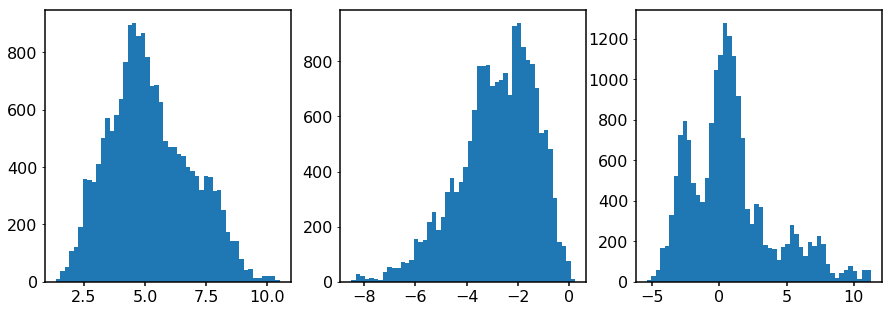

In [6]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(w0, bins=50)
ax[1].hist(w1, bins=50)
ax[2].hist(b, bins=50)

We can observe several things :
  * The histograms are not perfectly smooth, which indicate that the sampling process is most certainly not optimal. We should run it for a longer time or, better, use MCMC methods which are more efficient at exploring the parameter space. Although the sampling is imperfect, it will serve our purpose.
  * The values computed by the logistic regression do not correpond to the maximum of these variables independantly.
  
  
 With that chain, we can compute the contours of what would be obtained in terms of prediction using the bayesian method. For comparison, we also include the decision boundary of the regular logistic regression (corresponding to a sigmoid value of 0.5).

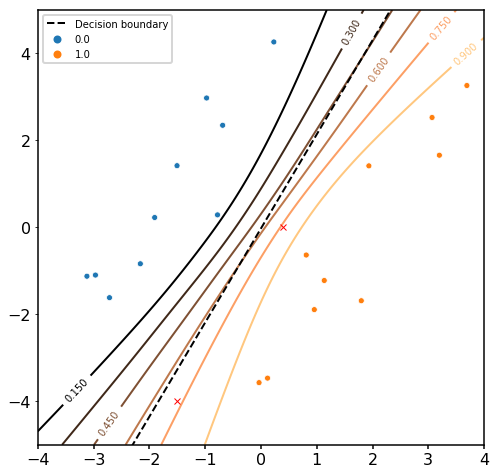

In [13]:
val2 = np.zeros(shape=val.shape) 
for j in range(10000):
    k = np.random.randint(0,len(sample),1)
    tmp = sigmoid(w0[k], w1[k], b[k], x0, x1)
    val2+=tmp
val2 = val2/10000

fig, ax = plt.subplots(1,1,figsize=(8,8))
make_scatter_plot(data,y, ax=ax)
cs = ax.contour(X0, X1, val2, cmap='copper')
plt.clabel(cs, inline=True,fontsize=10)
ax.plot(x0,-W_opt[0]/W_opt[1]*x0-b_opt/W_opt[1],'k--', label='Decision boundary')
ax.set_xlim(-4,4)
ax.set_ylim(-5,5)
ax.legend()
ax.plot(-1.5, -4., 'rx')
ax.plot(0.4, 0., 'rx')


Surprisingly, the contours of equal prediction value are no longer linear! But this actually makes perfectly sense if we think about it. The Bayesian logistic regression takes into account the density of data and is much more uncertain of the true label is at location that far away from training data.

For instance, if we compare the predictions that would be made at the two points marked by a red cross in the previous graph.
The logistic regression would classify both point with the same confidence.
The Bayesian logistic regression would be less confident for the point in the lower left because it has no much clue of what the data distribution is in that region.